# Image Classification with CNN using Keras

## Step 1: Import Libraries

In [3]:
import tensorflow as tf
import os
import numpy as np

# import inline plotter
from matplotlib import pyplot as plt
%matplotlib inline

# create models directory
if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.2.0
Is using GPU? False


## Step 2: Preprocess Data

In [10]:
# only use the first 3 classes from entire CIFAR dataset to speed up processing
# store indices where y = 0-2 into variables indices_[y]
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)
    
    # concatenate indices along the first axis
    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    # select only examples and labels corresponding to indices
    x = x[indices]
    y = y[indices]
    
    # shuffle indices and ensure they are unique
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    # store newly shuffled indices
    x = x[indices]
    y = y[indices]
    
    # convert labels to hard-encoded vectors
    y = tf.keras.utils.to_categorical(y)
    
    return x,y

In [11]:
# testing output
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# notice the datasets are reduced from their original size since we split them evenly among the classes

170500096/170498071 [==============================] - 21s 0us/step
(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


## Step 3: Visualize Examples

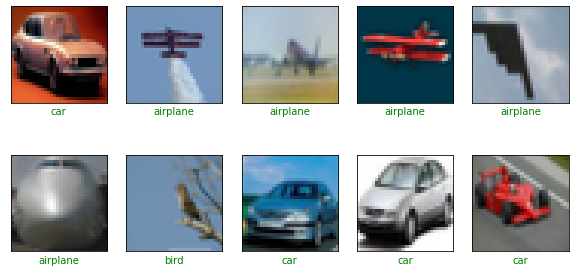

In [16]:
# view these classes
class_names = ['airplane', 'car', 'bird']

# view the examples, labels, and prediction if any
def show_random_examples(x, y, p):
    # show examples from list of total choices (x.shape) with certain number of total examples (10) and ensure they are unique
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    # update indices
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    # create plot
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, 1 + i)
        plt.imshow(x[i])
        # formatting
        plt.xticks([])
        plt.yticks([])
        # color-code predictions
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()
    
show_random_examples(x_train, y_train, y_train)
# we have no predictions yet so pass y model twice

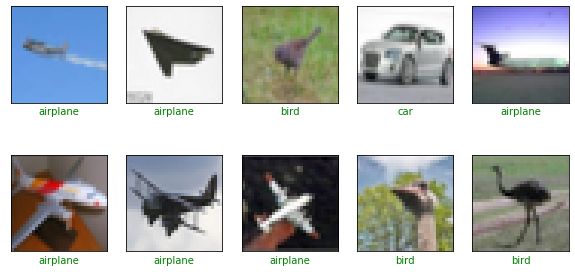

In [17]:
show_random_examples(x_test, y_test, y_test)

## Step 4: Create Model

In [19]:
# import different layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

# create the model
def create_model():
    # add convolution block with layers
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        
        return model
    
    # instantiate keras sequential model
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    # add convolution blocks with specified number of filters into model
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)

    # flatten final block output
    model.add(Flatten())
    # distribute probability across all 3 classes
    model.add(Dense(3, activation='softmax'))
    
    # compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam', metrics=['accuracy']
    )
    
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

## Step 5: Train the Model

In [29]:
# return what happened during training process
h = model.fit(
    # normalize pixel values (255px) for our examples to range 0-1
    x_train/255., y_train,
    validation_data=(x_test/255., y_test),
    # training run settings
    epochs=10, batch_size=128,
    # monitor callbacks to monitor training process
    callbacks=[
        # if validation accuracy doesn't improve for 3 epochs, stop training and refine parameters
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        # save models from training. save only the best models in models directory
        tf.keras.callbacks.ModelCheckpoint(
            # filename
            'models/model_{val_accuracy:.3f}.h5',
            save_best_only=True, save_weights_only=False,
            monitor='val_accuracy'
        )
    ]
)

Epoch 1/10
118/118 [==============================] - 24s 207ms/step - loss: 0.3955 - accuracy: 0.8458 - val_loss: 0.6800 - val_accuracy: 0.7500
Epoch 2/10
118/118 [==============================] - 25s 208ms/step - loss: 0.3594 - accuracy: 0.8608 - val_loss: 0.5129 - val_accuracy: 0.8083
Epoch 3/10
118/118 [==============================] - 25s 212ms/step - loss: 0.3420 - accuracy: 0.8694 - val_loss: 0.3050 - val_accuracy: 0.8813
Epoch 4/10
118/118 [==============================] - 26s 219ms/step - loss: 0.3149 - accuracy: 0.8777 - val_loss: 0.2888 - val_accuracy: 0.8820
Epoch 5/10
118/118 [==============================] - 26s 219ms/step - loss: 0.2981 - accuracy: 0.8841 - val_loss: 0.2831 - val_accuracy: 0.8867
Epoch 6/10
118/118 [==============================] - 26s 220ms/step - loss: 0.2833 - accuracy: 0.8919 - val_loss: 0.2678 - val_accuracy: 0.8907
Epoch 7/10
118/118 [==============================] - 24s 207ms/step - loss: 0.2646 - accuracy: 0.8972 - val_loss: 0.4125 - val_ac

## Step 6: Final Predictions

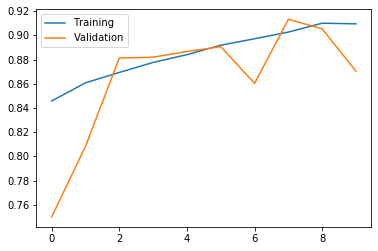

In [31]:
# view accuracy report during training
accs = h.history['accuracy']
# view validation accuracy
val_accs = h.history['val_accuracy']

# x-axis = epochs
plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(accs)), val_accs, label='Validation')
plt.legend()
plt.show()

In [32]:
# view best performing model
model = tf.keras.models.load_model('models/model_0.913.h5')

In [33]:
# get predictions
preds = model.predict(x_test/255.)

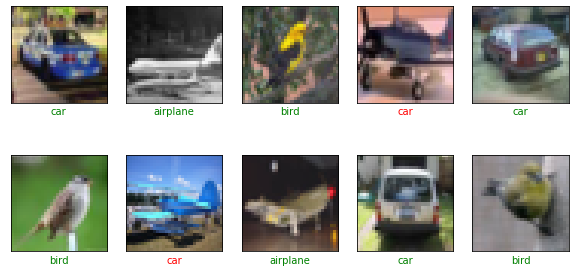

In [35]:
# show predictions
show_random_examples(x_test, y_test, preds)